# Recuperação dos Dados

In [1]:
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics

In [277]:
df_daily_demand = pd.read_csv("Dados/daily_demand.csv")

In [278]:
df_daily_demand

,datehour,total,isholiday,isnearholiday,isweekend,ma_total,date,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
0,2017-01-01 00:00:00,249.0,False,True,True,382.500000,2017-01-01,44.0,48.0,40.0,0.00,0.0,0.0
1,2017-01-01 01:00:00,246.0,False,True,True,382.500000,2017-01-01,44.0,48.0,40.0,0.00,0.0,0.0
2,2017-01-01 02:00:00,199.0,False,True,True,382.500000,2017-01-01,44.0,48.0,40.0,0.00,0.0,0.0
3,2017-01-01 03:00:00,146.0,False,True,True,382.500000,2017-01-01,44.0,48.0,40.0,0.00,0.0,0.0
4,2017-01-01 04:00:00,66.0,False,True,True,382.500000,2017-01-01,44.0,48.0,40.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2019-12-31 19:00:00,782.0,False,False,False,846.200000,2019-12-31,40.5,45.0,36.0,0.02,0.0,0.0
26276,2019-12-31 20:00:00,505.0,False,False,False,848.900000,2019-12-31,40.5,45.0,36.0,0.02,0.0,0.0
26277,2019-12-31 21:00:00,386.0,False,False,False,847.200000,2019-12-31,40.5,45.0,36.0,0.02,0.0,0.0
26278,2019-12-31 22:00:00,390.0,False,False,False,849.033333,2019-12-31,40.5,45.0,36.0,0.02,0.0,0.0


In [279]:
df_daily_demand["datehour"] = pd.to_datetime(df_daily_demand["datehour"])

In [280]:
df_daily_demand = (
    df_daily_demand
    .set_index("datehour")
    .asfreq("H")
    .drop("date", axis=1)
)

In [281]:
df_daily_demand.head()

,total,isholiday,isnearholiday,isweekend,ma_total,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD
datehour,,,,,,,,,,,
2017-01-01 00:00:00,249.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 01:00:00,246.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 02:00:00,199.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 03:00:00,146.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0
2017-01-01 04:00:00,66.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,0.0


## Testando Calendário Fourier

In [282]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [283]:
fourierAnnual = CalendarFourier(freq="D", order=24)  # 10 sin/cos pairs for "A"nnual seasonality
fourierWeekly = CalendarFourier(freq="W", order=7)  # 10 sin/cos pairs for "A"nnual seasonality

In [284]:
dp = DeterministicProcess(
    index=df_daily_demand.index,
    constant=True,                           # dummy feature for bias (y-intercept)
    order=1,                                 # trend (order 1 means linear)
    seasonal=True,                           # weekly seasonality (indicators)
    additional_terms=[fourierAnnual, fourierWeekly],        
    drop=True,                               # drop terms to avoid collinearity
)

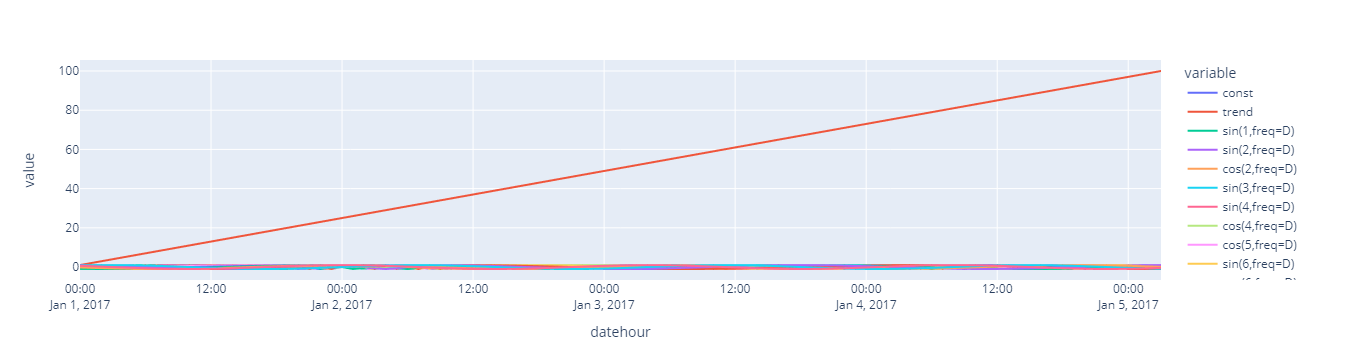

In [285]:
fourier_data = dp.in_sample().copy()
px.line(fourier_data.iloc[:100])

In [286]:
df_daily_demand = pd.concat([df_daily_demand, fourier_data], axis=1)

In [287]:
df_daily_demand.head()

,total,isholiday,isnearholiday,isweekend,ma_total,TAVG,TMAX,TMIN,PRCP,SNOW,...,"sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","cos(4,freq=W-SUN)","sin(5,freq=W-SUN)","cos(5,freq=W-SUN)","sin(6,freq=W-SUN)","cos(6,freq=W-SUN)"
datehour,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,249.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.974928,-2.225209e-01,-0.433884,-0.900969,4.338837e-01,-0.900969,0.974928,-0.222521,0.781831,6.234898e-01
2017-01-01 01:00:00,246.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.988831,-1.490423e-01,-0.532032,-0.846724,2.947552e-01,-0.955573,0.916562,-0.399892,0.900969,4.338837e-01
2017-01-01 02:00:00,199.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.997204,-7.473009e-02,-0.623490,-0.781831,1.490423e-01,-0.988831,0.826239,-0.563320,0.974928,2.225209e-01
2017-01-01 03:00:00,146.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-1.000000,-4.286264e-16,-0.707107,-0.707107,8.572528e-16,-1.000000,0.707107,-0.707107,1.000000,-4.904777e-16
2017-01-01 04:00:00,66.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.997204,7.473009e-02,-0.781831,-0.623490,-1.490423e-01,-0.988831,0.563320,-0.826239,0.974928,-2.225209e-01


## Divisão em Treino/Validação/Teste

In [288]:
df_train, df_test = model_selection.train_test_split(df_daily_demand, test_size=1/3, shuffle=False)
df_test, df_val = model_selection.train_test_split(df_test, test_size=0.50, shuffle=False) # 0.25 x 0.8 = 0.2

In [289]:
len(df_train)

17520

In [290]:
len(df_test)

4380

In [291]:
len(df_val)

4380

<AxesSubplot: xlabel='datehour'>

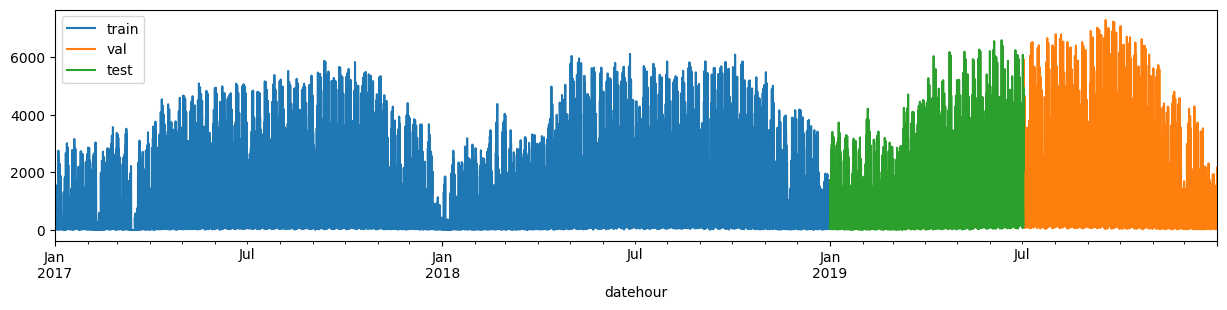

In [292]:
pd.concat([df_train.iloc[:,0].rename('train'), df_val.iloc[:,0].rename('val'), df_test.iloc[:,0].rename('test')], axis=1).plot(figsize=(15,3))

In [293]:
df_train.head()

,total,isholiday,isnearholiday,isweekend,ma_total,TAVG,TMAX,TMIN,PRCP,SNOW,...,"sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)","cos(4,freq=W-SUN)","sin(5,freq=W-SUN)","cos(5,freq=W-SUN)","sin(6,freq=W-SUN)","cos(6,freq=W-SUN)"
datehour,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,249.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.974928,-2.225209e-01,-0.433884,-0.900969,4.338837e-01,-0.900969,0.974928,-0.222521,0.781831,6.234898e-01
2017-01-01 01:00:00,246.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.988831,-1.490423e-01,-0.532032,-0.846724,2.947552e-01,-0.955573,0.916562,-0.399892,0.900969,4.338837e-01
2017-01-01 02:00:00,199.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.997204,-7.473009e-02,-0.623490,-0.781831,1.490423e-01,-0.988831,0.826239,-0.563320,0.974928,2.225209e-01
2017-01-01 03:00:00,146.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-1.000000,-4.286264e-16,-0.707107,-0.707107,8.572528e-16,-1.000000,0.707107,-0.707107,1.000000,-4.904777e-16
2017-01-01 04:00:00,66.0,False,True,True,382.5,44.0,48.0,40.0,0.0,0.0,...,-0.997204,7.473009e-02,-0.781831,-0.623490,-1.490423e-01,-0.988831,0.563320,-0.826239,0.974928,-2.225209e-01


# Modelagem

In [294]:
from keras.preprocessing import sequence 
from keras.models import Sequential 
from keras.layers import Dense, Embedding 

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [295]:
n_features = len(df_train.columns)-1

print(n_features)

47


In [298]:
values = df_train.values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train = scaled

In [299]:
values = df_val.values.astype('float32')

# normalize features
scaled = scaler.fit_transform(values)

val = scaled

In [302]:
values = df_test.values.astype('float32')

# normalize features
scaled = scaler.fit_transform(values)

test = scaled

In [303]:
print(train.shape, val.shape, test.shape)

(17520, 48) (4380, 48) (4380, 48)


In [304]:
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
val_X, val_y = val[:, 1:], val[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)

(17520, 47) (4380, 47) (4380, 47) (17520,) (4380,) (4380,)


In [305]:
# design network
model = Sequential()
model.add(Dense(units=32, input_dim=n_features, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse', 'mae'])

In [306]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 32)                1536      
                                                                 
 dense_47 (Dense)            (None, 300)               9900      
                                                                 
 dense_48 (Dense)            (None, 100)               30100     
                                                                 
 dense_49 (Dense)            (None, 30)                3030      
                                                                 
 dense_50 (Dense)            (None, 10)                310       
                                                                 
 dense_51 (Dense)            (None, 1)                 11        
                                                                 
Total params: 44,887
Trainable params: 44,887
Non-tra

In [307]:
config = model.get_config() # Returns pretty much every information about your model
print(config["layers"][0]["config"]["batch_input_shape"]) # returns a tuple of width, height and channels

(None, 47)


In [308]:
train_X.shape

(17520, 47)

In [309]:
train_y.shape

(17520,)

In [310]:
# fit network
history = model.fit(
    train_X, train_y, 
    epochs=200, batch_size=50, 
    validation_data=(val_X, val_y), 
    verbose=0, shuffle=False
)

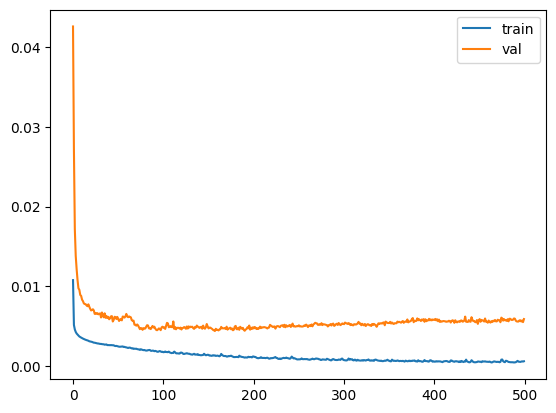

In [311]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [312]:
# make a prediction
yhat = pd.Series(model.predict(test_X).flatten())
new_test_X = test_X.reshape((test_X.shape[0], n_features))

137/137 [==============================] - 0s 2ms/step


In [313]:
# test_X[[0]]

In [314]:
yhat

0       0.049489
1       0.038301
2       0.027748
3       0.040048
4       0.015587
          ...   
4375    0.520831
4376    0.934475
4377    0.583055
4378    0.329250
4379    0.363342
Length: 4380, dtype: float32

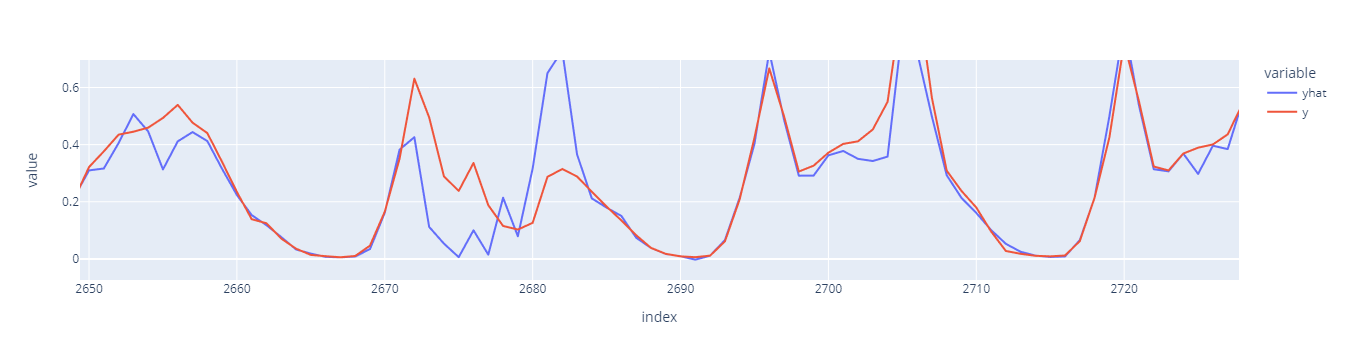

In [315]:
px.line(pd.DataFrame({
    "yhat": yhat,
    "y": test_y
}))

In [316]:
df_test.values.shape

(4380, 48)

In [317]:
pd.concat([yhat, pd.DataFrame(new_test_X[:, 1:])], axis=1, ignore_index=True).shape

(4380, 47)

In [318]:
test_X.shape

(4380, 47)

Para realizar a inversão, precisamos que o dataframe esteja no mesmo formato de quando usamos o scaler, ou seja, primeira coluna com o y real e as demais com os valores, porém, sem a transformação de tempo. Teremos apenas as colunas originais dos tempos (t).

In [319]:
pd.concat([yhat, pd.DataFrame(new_test_X[:, -(n_features):])], axis=1, ignore_index=True)

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.049489,1.0,0.0,0.0,0.106445,0.544828,0.571429,0.521127,0.045113,0.0,...,0.987464,0.388740,0.716942,0.049516,0.282450,0.049516,0.012536,0.388740,0.109084,0.811745
1,0.038301,1.0,0.0,0.0,0.099412,0.544828,0.571429,0.521127,0.045113,0.0,...,0.977786,0.352622,0.665140,0.028058,0.217550,0.086881,0.000350,0.481304,0.188255,0.890916
2,0.027748,1.0,0.0,0.0,0.094706,0.544828,0.571429,0.521127,0.045113,0.0,...,0.965437,0.317329,0.611260,0.012536,0.158960,0.133474,0.005585,0.574521,0.283058,0.950484
3,0.040048,1.0,0.0,0.0,0.089735,0.544828,0.571429,0.521127,0.045113,0.0,...,0.950484,0.283058,0.555982,0.003144,0.107988,0.188255,0.028058,0.665140,0.388740,0.987464
4,0.015587,1.0,0.0,0.0,0.085384,0.544828,0.571429,0.521127,0.045113,0.0,...,0.933013,0.250000,0.500000,0.000000,0.065773,0.250000,0.066987,0.750000,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,0.520831,0.0,0.0,0.0,0.663310,0.951724,0.922078,0.971831,0.015038,0.0,...,0.866526,0.159914,0.334860,0.028058,0.000000,0.462635,0.266366,0.942058,0.811745,0.890916
4376,0.934475,0.0,0.0,0.0,0.724179,0.951724,0.922078,0.971831,0.015038,0.0,...,0.840086,0.133474,0.283058,0.049516,0.000000,0.537365,0.352622,0.977786,0.890916,0.811745
4377,0.583055,0.0,0.0,0.0,0.769983,0.951724,0.922078,0.971831,0.015038,0.0,...,0.811745,0.109084,0.233984,0.076638,0.011169,0.611260,0.444018,0.996856,0.950484,0.716942
4378,0.329250,0.0,0.0,0.0,0.795497,0.951724,0.922078,0.971831,0.015038,0.0,...,0.781660,0.086881,0.188255,0.109084,0.033258,0.682671,0.537365,0.998602,0.987464,0.611260


In [320]:
inv_yhat = pd.concat([yhat, pd.DataFrame(new_test_X[:, -(n_features):])], axis=1, ignore_index=True)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [321]:
test_y = pd.Series(test_y.flatten())
inv_y = pd.concat([test_y, pd.DataFrame(new_test_X[:, -(n_features):])], axis=1, ignore_index=True)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [339]:
from sklearn import metrics
import math

def print_metrics(y_test, y_pred):
    df_diff = pd.Series(y_test - y_pred)
    mse = pd.Series(df_diff ** 2).replace(np.inf, np.nan).dropna().mean()
    rmse = math.sqrt(mse)
    mape = abs(df_diff/y_test).replace(np.inf, np.nan).dropna().mean()
    medianae = abs(df_diff).replace(np.inf, np.nan).dropna().mean()
    meanae = abs(df_diff).replace(np.inf, np.nan).dropna().median()

    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE:", mape)
    print("MedianAE:", medianae)
    print("MeanAE:", meanae)

In [340]:
print_metrics(inv_y, inv_yhat)

MSE: 261706.52
RMSE: 511.5725907679183
MAPE: 0.43056428
MedianAE: 301.6645
MeanAE: 142.86017
